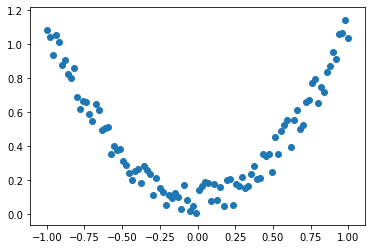

In [1]:
import torch
import matplotlib.pyplot as plt

x = torch.unsqueeze(torch.linspace(-1, 1, 100), dim=1)  # x data (tensor), shape=(100, 1)
y = x.pow(2) + 0.2*torch.rand(x.size())                 # noisy y data (tensor), shape=(100, 1)


# print(x)
# print(y)
# 画图
plt.scatter(x.data.numpy(), y.data.numpy())
plt.show()

In [8]:
from airplane import Airplane
from receiver import Receiver

airplane1 = Airplane('782034',[120.128234,30.2141348,10000],[115.86143245,28.750012,10000],180,3340)
receiver1 = Receiver([114.122588,36.548925,1000])
time_track1 =receiver1.fin_time_track(airplane1)
track1 = airplane1.track

5247 5247


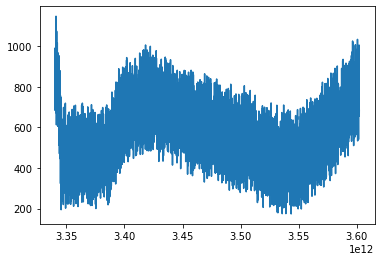

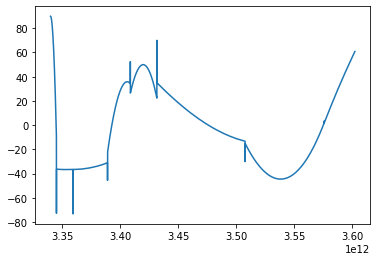

In [9]:
# 获取前后数据包时间差
import matplotlib.pyplot as plt
from math import radians, cos, sin, asin, sqrt,pi, atan

using_data = time_track1
time_error = []
location_error = []
print(len(track1),len(using_data))

for i in range(len(using_data)-1):
    time_error.append(using_data[i+1]-using_data[i]-50000000)#-(airplane1.geodistance(track1[i+1],receiver1.location)-airplane1.geodistance(track1[i],receiver1.location))*10/3)
    location_error.append(airplane1.geodistance(track1[i+1],receiver1.location)-airplane1.geodistance(track1[i],receiver1.location))
    
# plt.plot(using_data[19:79], test_data[19:79])
plt.plot(using_data[:-1], time_error)
plt.show()
# plt.ylim(0.39,0.6)
# plt.xlim(0.39,0.6)
plt.plot(using_data[:-1], location_error)
plt.show()


In [10]:
# 划分训练集和测试集
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

x_data = torch.tensor(time_error)
y_data = torch.tensor(location_error)
print(x_data)
print(y_data)

test_size = 1000

x_train_set = time_error[: -test_size]
x_test_set = time_error[-test_size:]

y_train_set = location_error[: -test_size]
y_test_set = location_error[-test_size:]


tensor([940.1021, 938.6782, 684.0791,  ..., 962.5283, 655.7334, 682.7607])
tensor([89.9251, 89.9097, 89.8752,  ..., 60.5972, 60.6982, 60.7972])


In [25]:
# 训练集数据归一化，并化为cuda类型
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range=(-1,1))

x_train_set_array = np.array(x_train_set)
x_train_norm = sc.fit_transform(x_train_set_array.reshape(-1,1))
x_train_norm = torch.Tensor(x_train_norm).cuda()

y_train_set_array = np.array(y_train_set)
y_train_norm = sc.fit_transform(y_train_set_array.reshape(-1,1))
y_train_norm = torch.Tensor(y_train_norm).cuda()

# train_set_array = np.array(train_set)
# train_norm = sc.fit_transform(train_set_array.reshape(-1,1))
# train_norm = torch.FloatTensor(train_norm).view(-1).cuda()


In [26]:
print(x_train_norm)

tensor([[ 0.5740],
        [ 0.5711],
        [ 0.0484],
        ...,
        [-0.0318],
        [-0.5140],
        [-0.2572]], device='cuda:0')


In [27]:
import torch
import torch.nn.functional as F     # 激励函数都在这

class Net(torch.nn.Module):  # 继承 torch 的 Module
    def __init__(self, n_feature, n_hidden, n_output):
        super(Net, self).__init__()     # 继承 __init__ 功能
        # 定义每层用什么样的形式
        self.hidden = torch.nn.Linear(n_feature, n_hidden)   # 隐藏层线性输出
        self.predict = torch.nn.Linear(n_hidden, n_output)   # 输出层线性输出

    def forward(self, x):   # 这同时也是 Module 中的 forward 功能
        # 正向传播输入值, 神经网络分析出输出值
        x = F.relu(self.hidden(x))      # 激励函数(隐藏层的线性值)
        x = self.predict(x)             # 输出值
        return x

net = Net(n_feature=1, n_hidden=10, n_output=1)
gpus = [0]   #使用哪几个GPU进行训练，这里选择0号GPU
net = torch.nn.DataParallel(net, device_ids=gpus).cuda()   #将模型转为cuda类型

print(net)  # net 的结构


DataParallel(
  (module): Net(
    (hidden): Linear(in_features=1, out_features=10, bias=True)
    (predict): Linear(in_features=10, out_features=1, bias=True)
  )
)


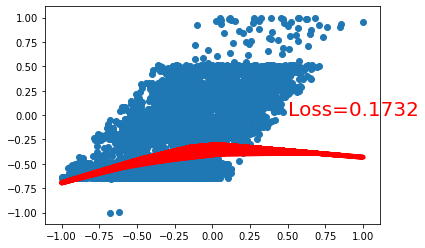

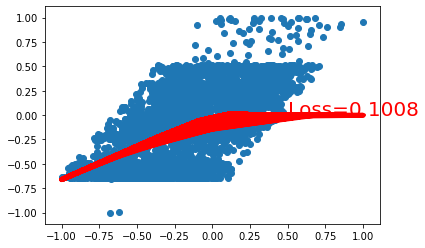

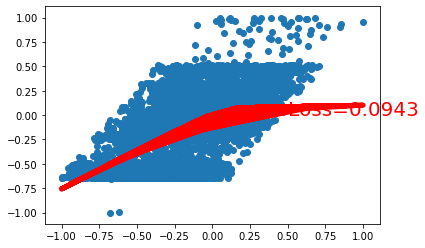

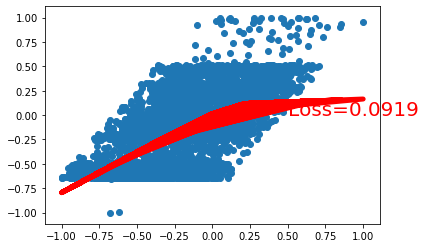

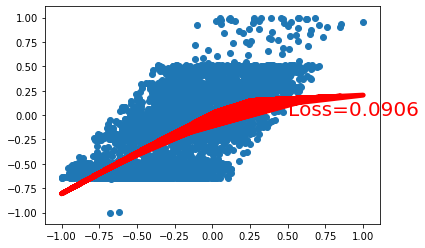

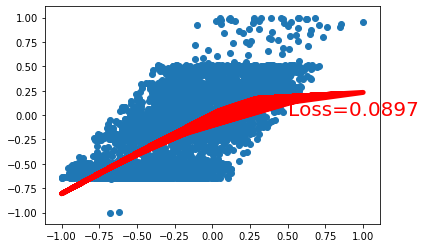

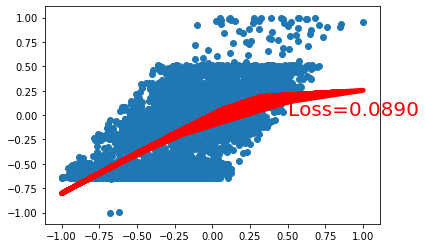

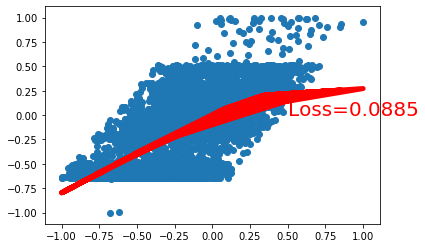

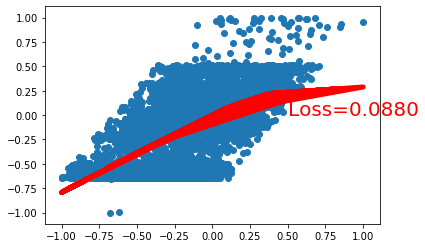

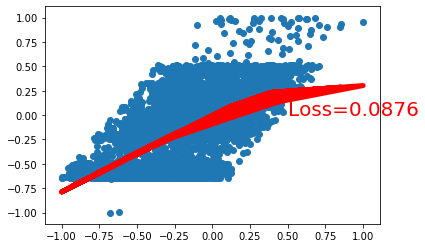

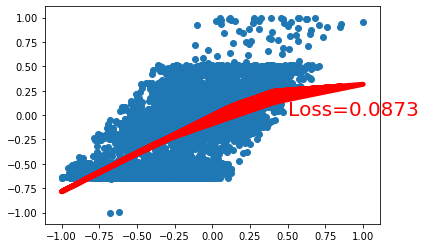

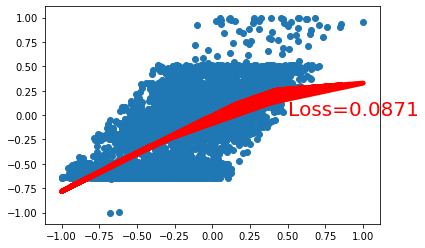

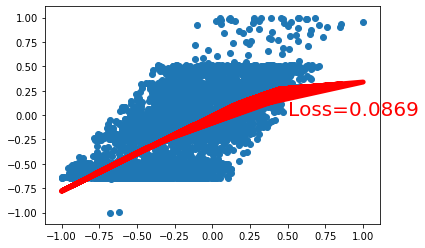

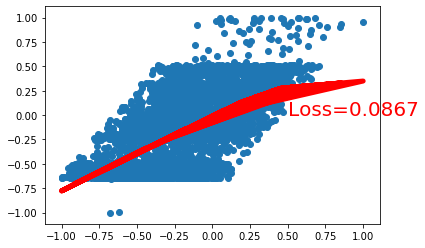

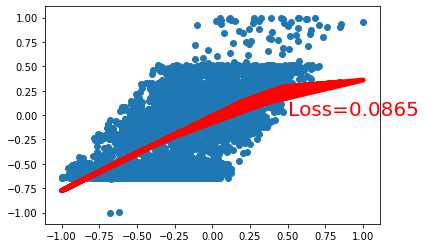

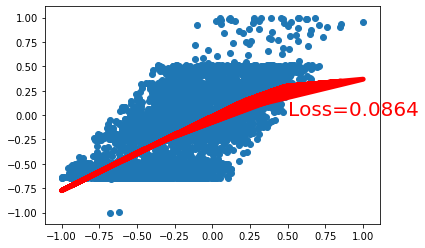

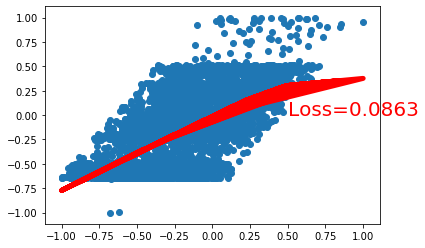

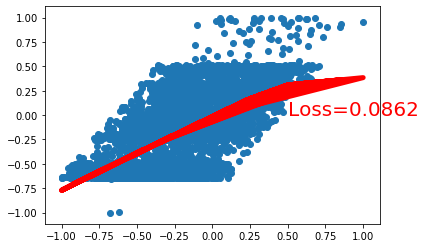

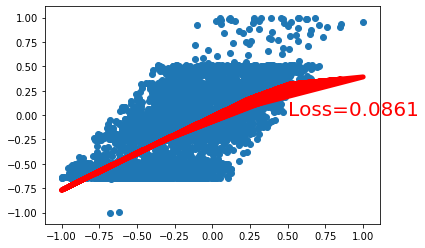

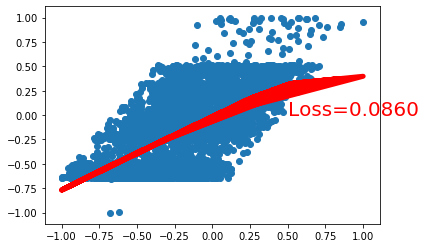

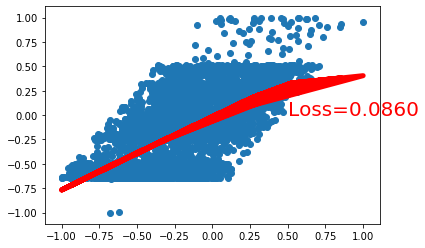

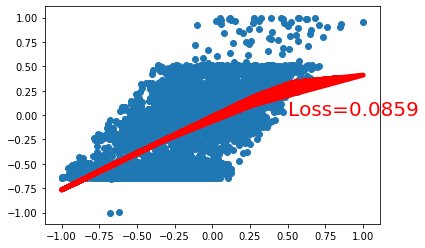

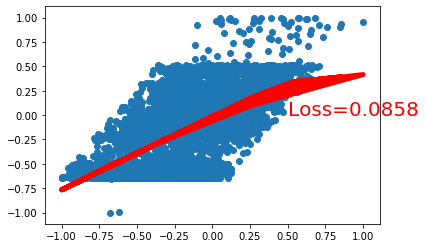

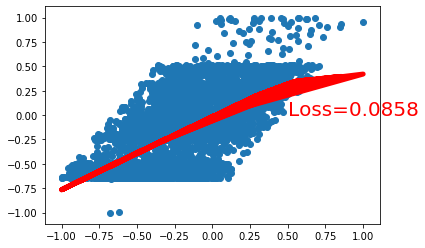

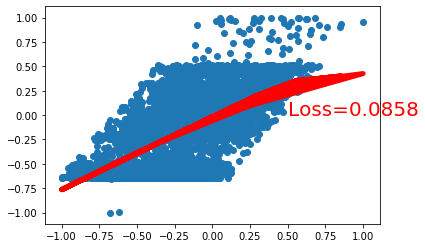

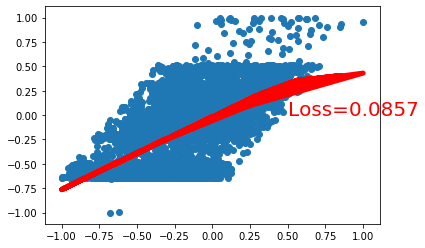

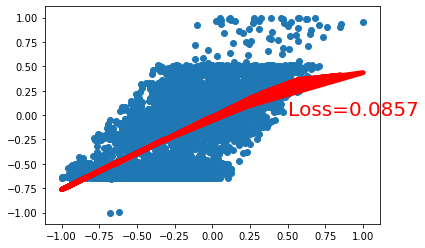

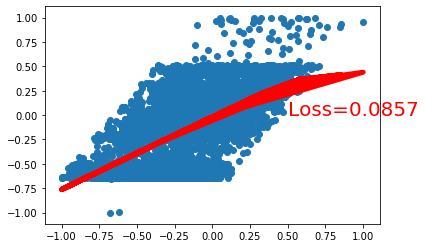

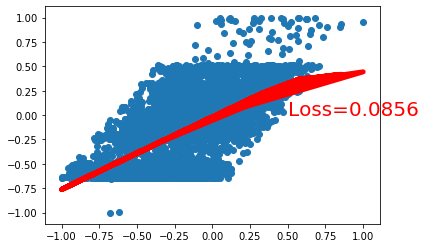

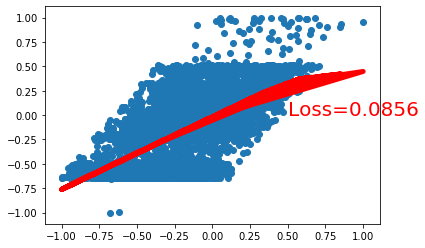

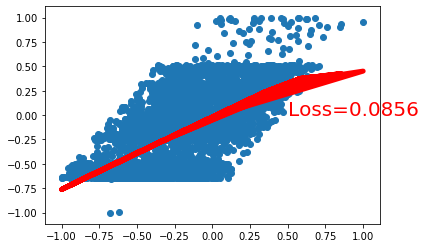

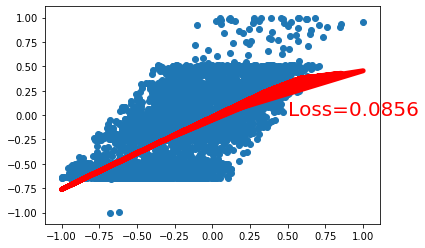

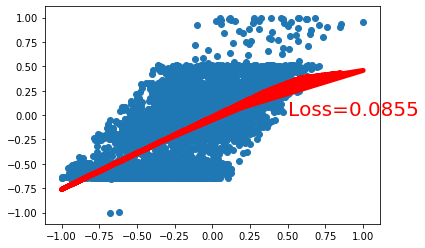

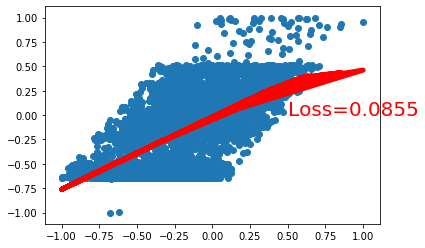

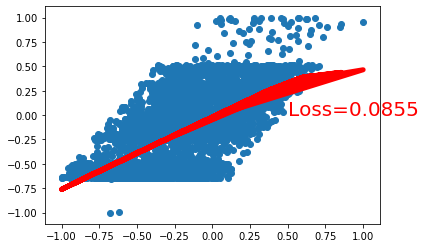

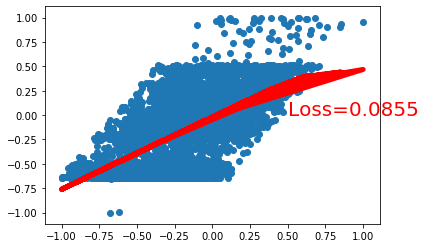

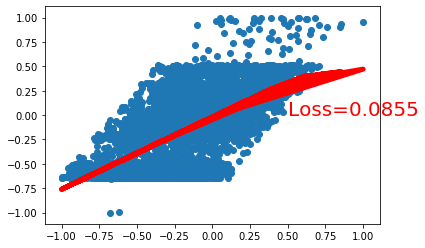

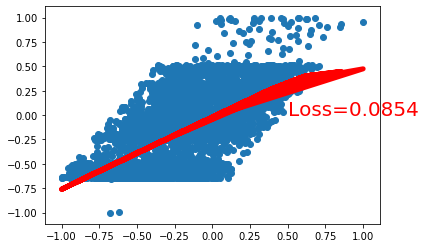

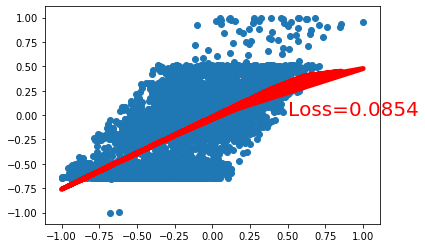

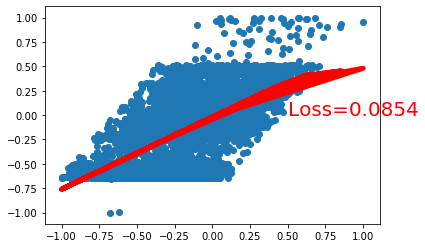

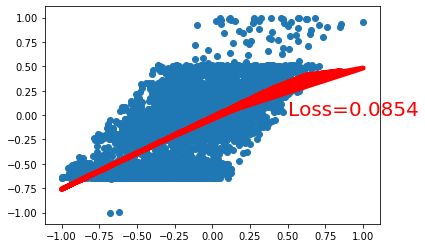

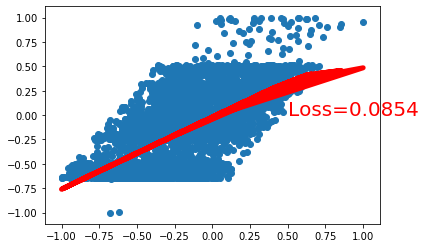

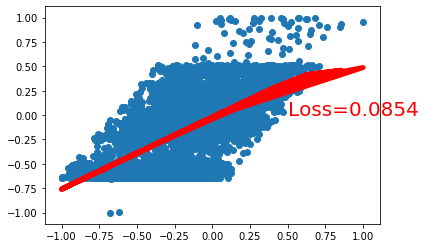

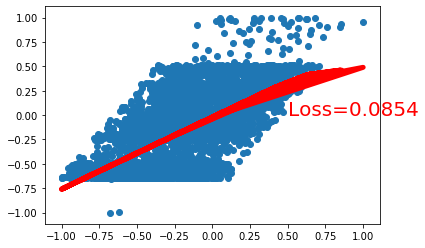

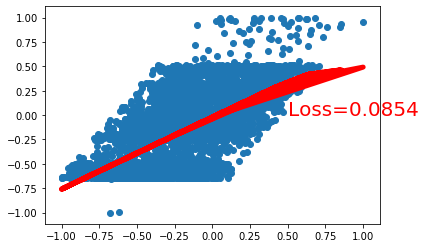

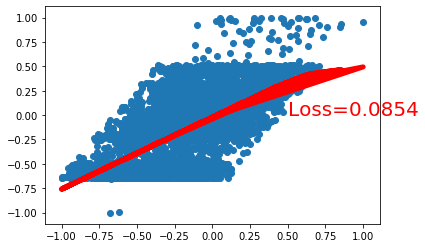

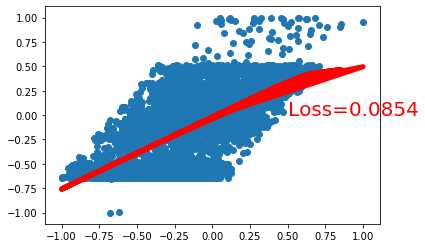

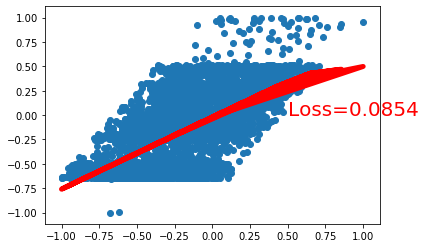

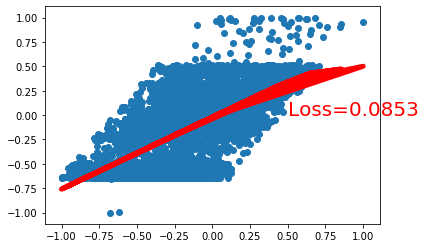

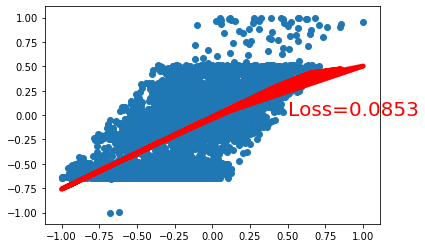

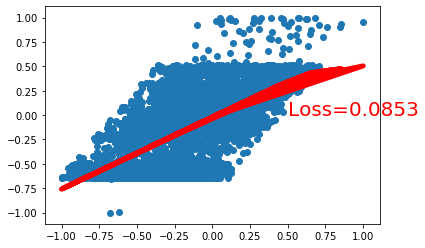

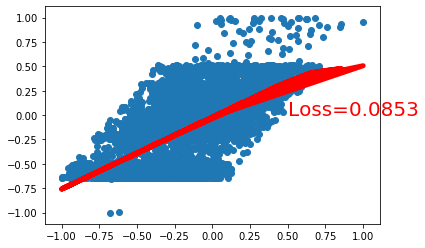

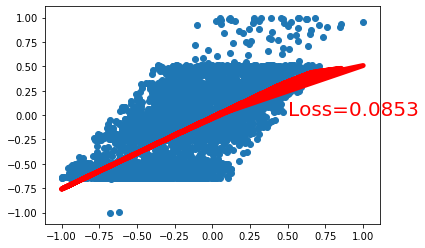

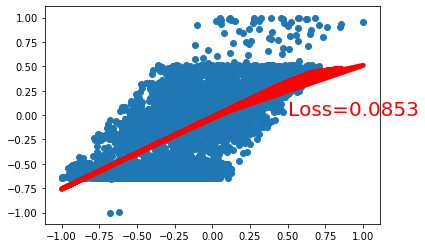

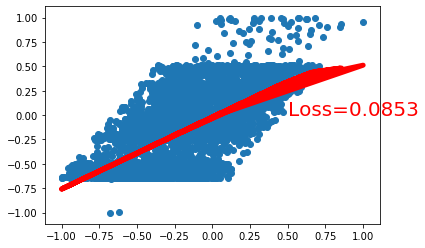

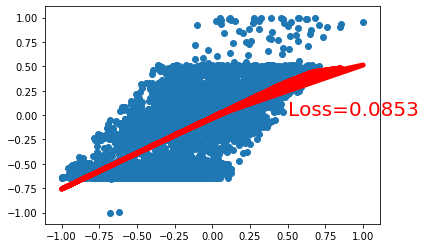

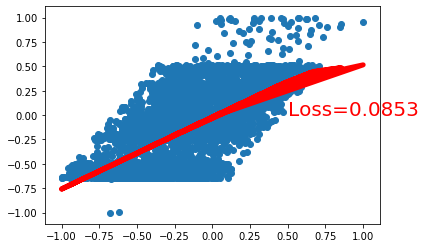

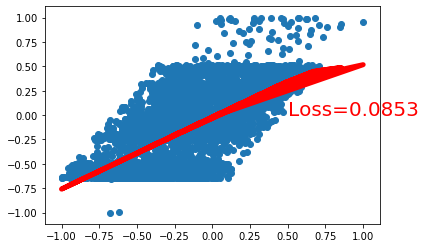

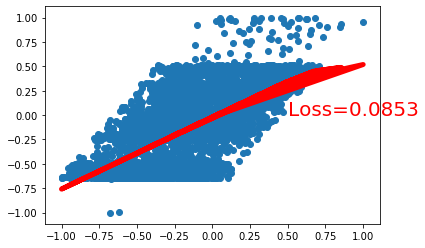

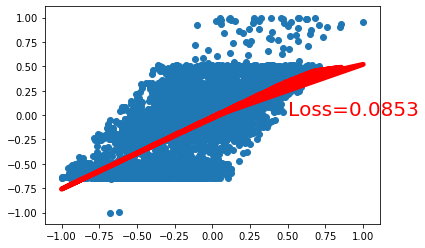

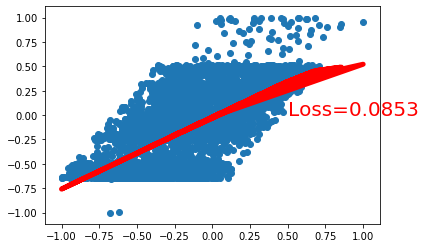

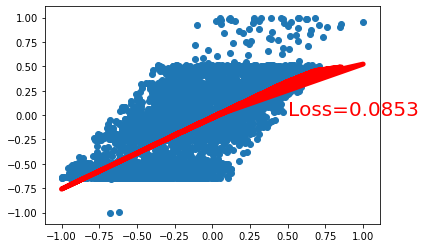

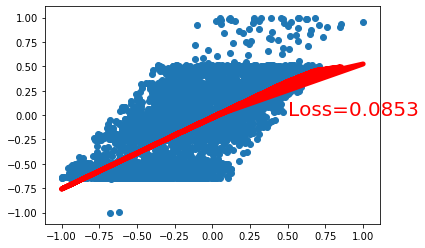

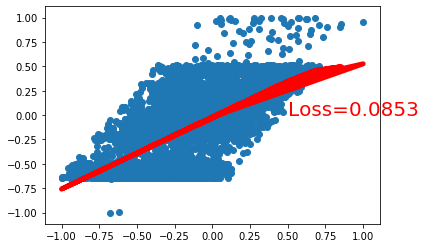

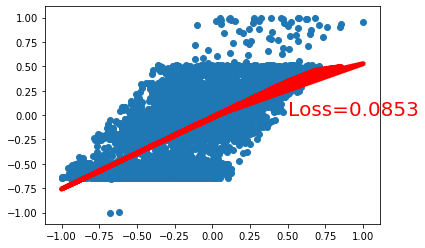

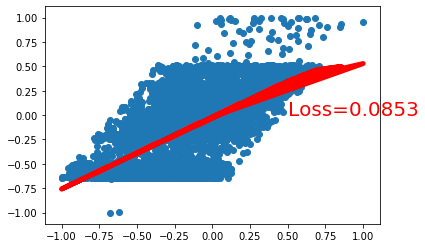

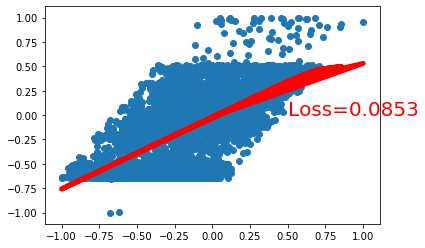

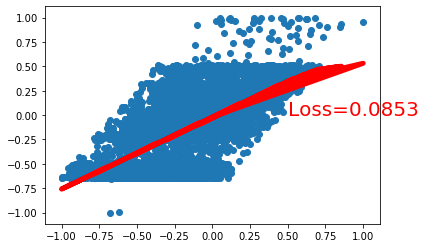

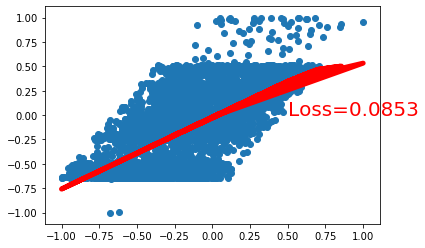

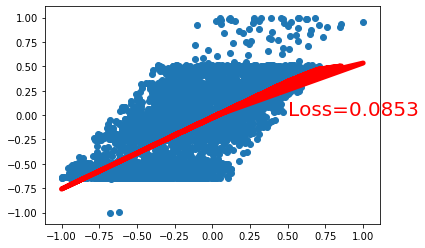

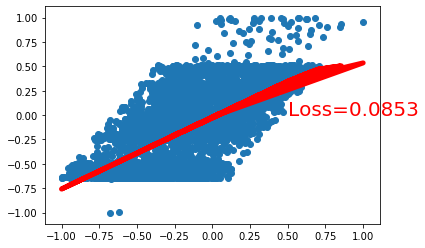

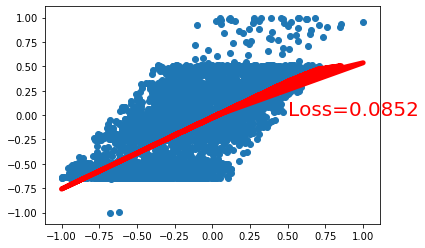

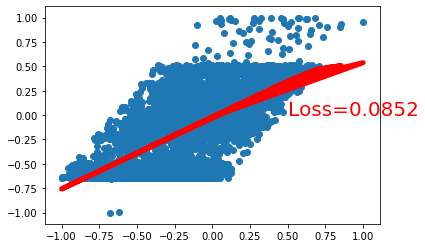

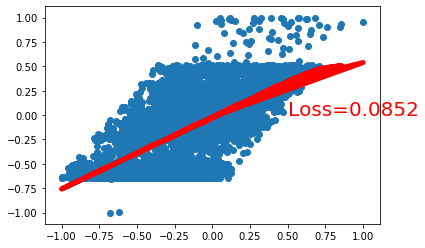

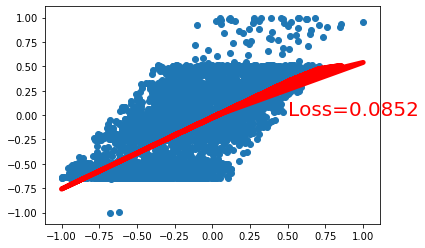

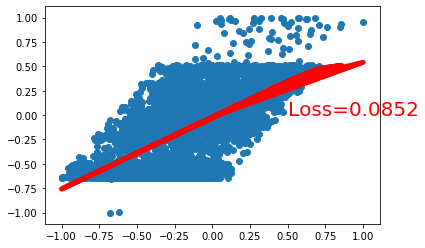

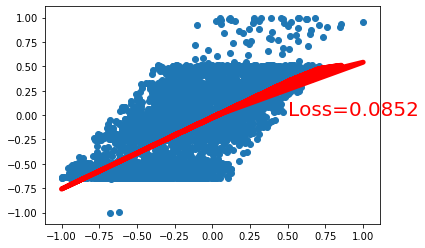

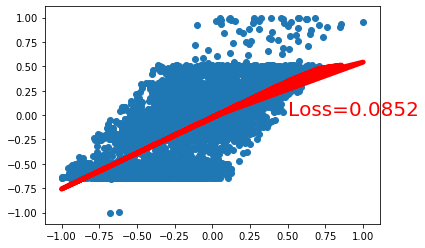

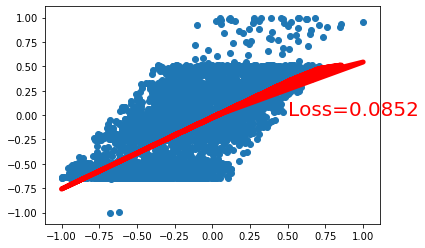

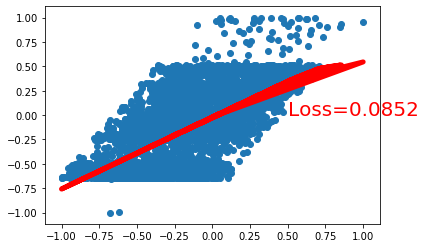

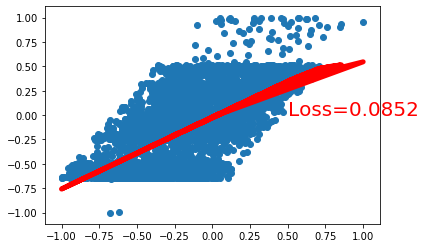

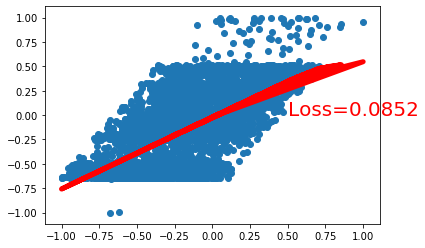

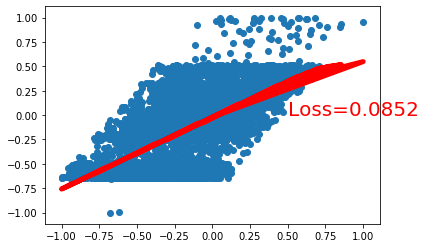

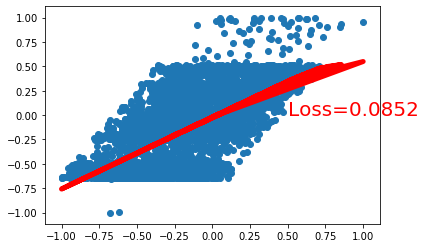

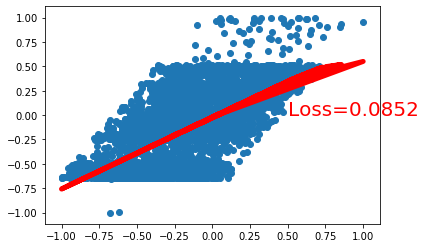

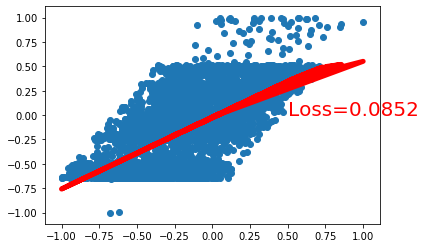

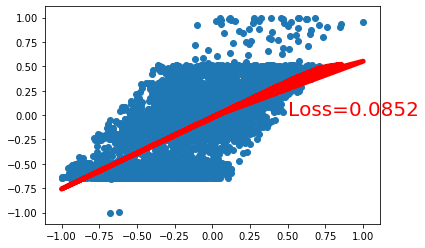

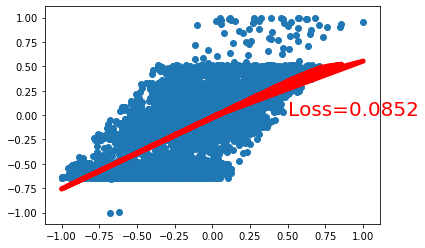

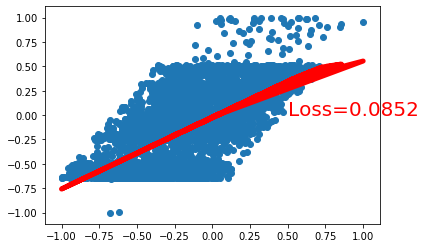

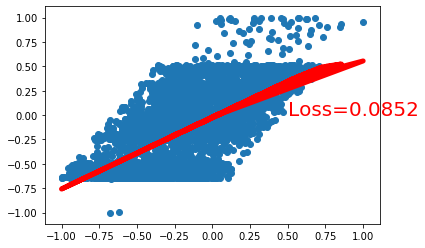

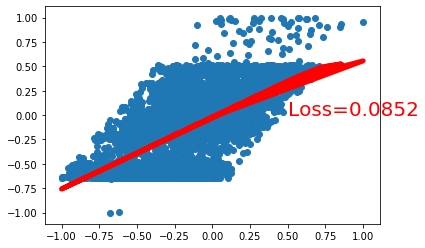

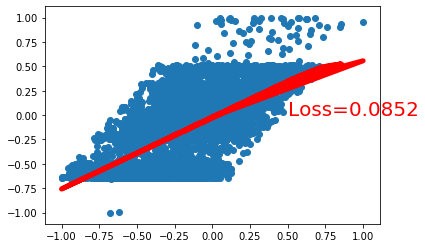

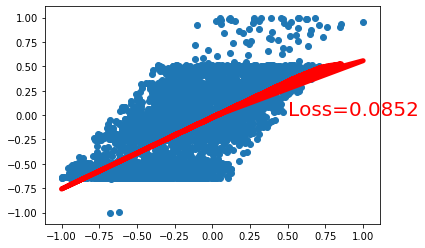

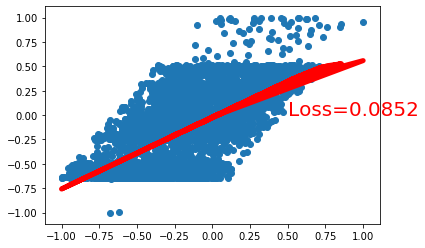

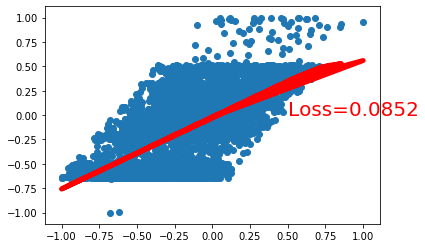

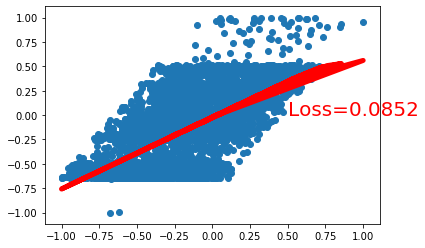

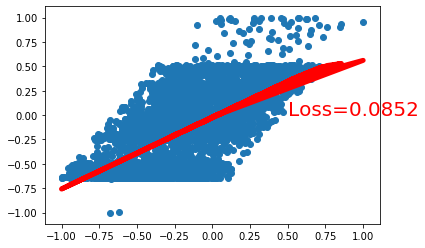

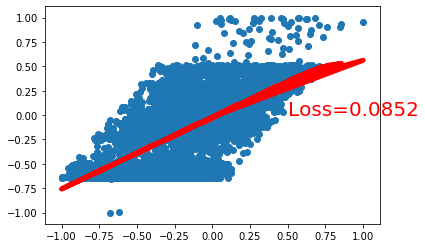

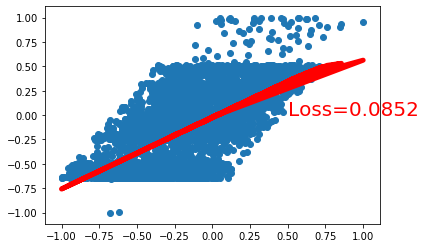

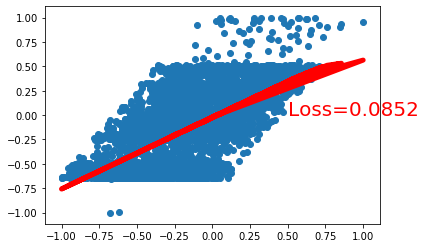

GPU time =  42.671865940093994


In [28]:
import matplotlib.pyplot as plt
import time

plt.ion()   # 画图
plt.show()

# optimizer 是训练的工具
optimizer = torch.optim.SGD(net.parameters(), lr=0.2)  # 传入 net 的所有参数, 学习率
loss_func = torch.nn.MSELoss()      # 预测值和真实值的误差计算公式 (均方差)

start_time = time.time()
for t in range(1000):
    
    prediction = net(x_train_norm)     # 喂给 net 训练数据 x, 输出预测值

    loss = loss_func(prediction, y_train_norm)     # 计算两者的误差

    optimizer.zero_grad()   # 清空上一步的残余更新参数值
    loss.backward()         # 误差反向传播, 计算参数更新值
    optimizer.step()        # 将参数更新值施加到 net 的 parameters 上

    if t % 10 == 0:
        # plot and show learning process
        plt.cla()
        plt.scatter(x_train_norm.data.cpu().numpy(), y_train_norm.data.cpu().numpy())
        plt.plot(x_train_norm.data.cpu().numpy(), prediction.data.cpu().numpy(), 'r-', lw=5)
        plt.text(0.5, 0, 'Loss=%.4f' % loss.data.cpu().numpy(), fontdict={'size': 20, 'color':  'red'})
        plt.pause(0.1)
#         print('Loss=%.4f' % loss.data.cpu().numpy())
        
elapsed_time = time.time() - start_time

print('GPU time = ',elapsed_time)


    # 接着上面来
#     if t % 5 == 0:
#         # plot and show learning process
#         plt.cla()
#         plt.scatter(x.data.cpu().numpy(), y.data.cpu().numpy())
#         plt.plot(x.data.cpu().numpy(), prediction.data.cpu().numpy(), 'r-', lw=5)
#         plt.text(0.5, 0, 'Loss=%.4f' % loss.data.cpu().numpy(), fontdict={'size': 20, 'color':  'red'})
#         plt.pause(0.1)
    
#     if t % 200 == 0:
#         # plot and show learning process
        
#         print('Loss=%.4f' % loss.data.cpu().numpy())

    

In [6]:
print(x)

tensor([[-1.0000],
        [-0.9798],
        [-0.9596],
        [-0.9394],
        [-0.9192],
        [-0.8990],
        [-0.8788],
        [-0.8586],
        [-0.8384],
        [-0.8182],
        [-0.7980],
        [-0.7778],
        [-0.7576],
        [-0.7374],
        [-0.7172],
        [-0.6970],
        [-0.6768],
        [-0.6566],
        [-0.6364],
        [-0.6162],
        [-0.5960],
        [-0.5758],
        [-0.5556],
        [-0.5354],
        [-0.5152],
        [-0.4949],
        [-0.4747],
        [-0.4545],
        [-0.4343],
        [-0.4141],
        [-0.3939],
        [-0.3737],
        [-0.3535],
        [-0.3333],
        [-0.3131],
        [-0.2929],
        [-0.2727],
        [-0.2525],
        [-0.2323],
        [-0.2121],
        [-0.1919],
        [-0.1717],
        [-0.1515],
        [-0.1313],
        [-0.1111],
        [-0.0909],
        [-0.0707],
        [-0.0505],
        [-0.0303],
        [-0.0101],
        [ 0.0101],
        [ 0.0303],
        [ 0.